In [60]:
import pickle


device = "cuda:0"

with open("data/train.pkl", "rb") as file:
    dataset = pickle.load(file)

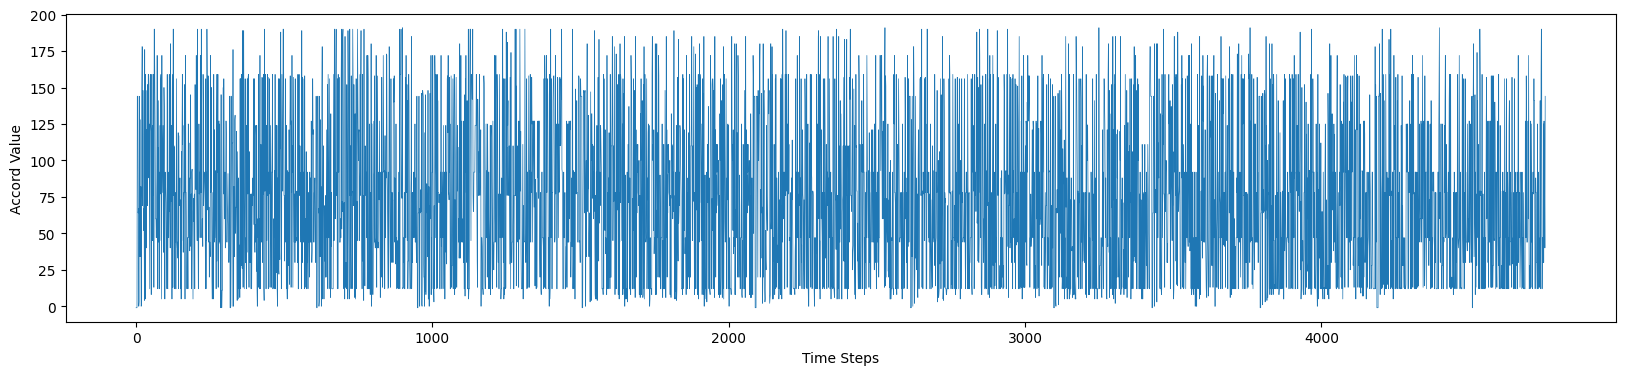

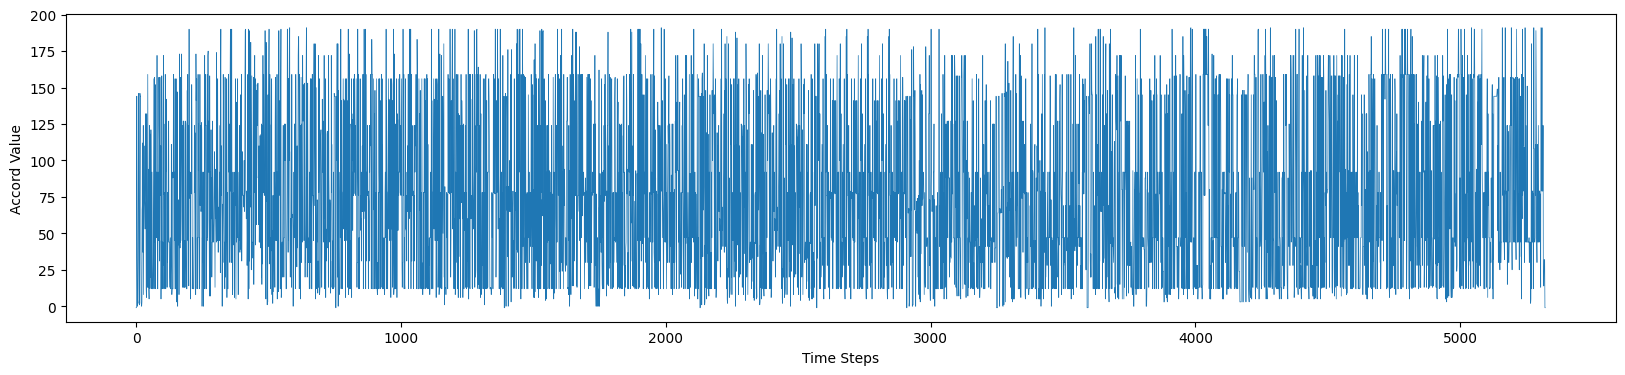

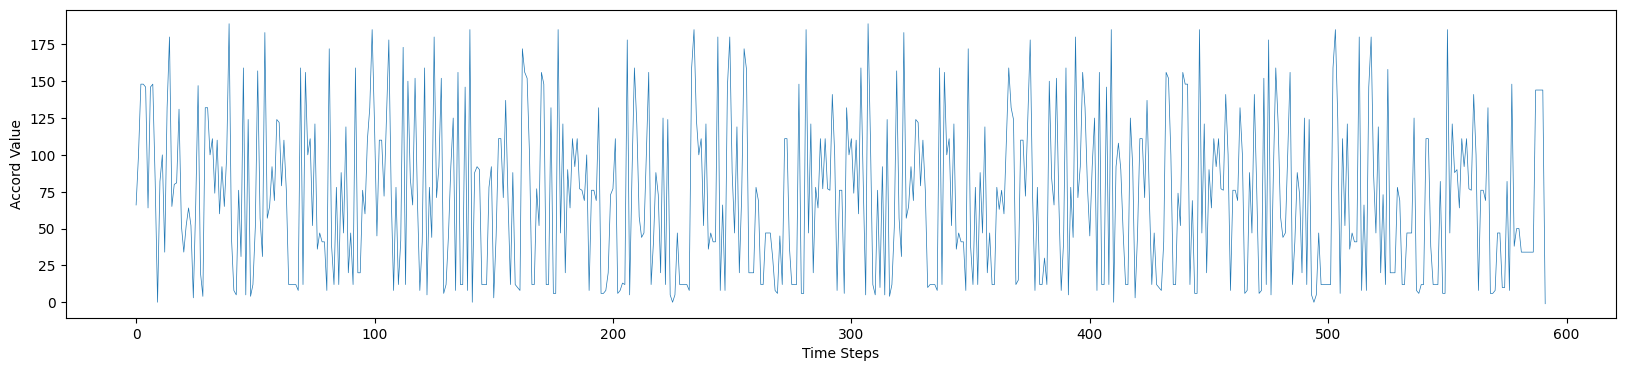

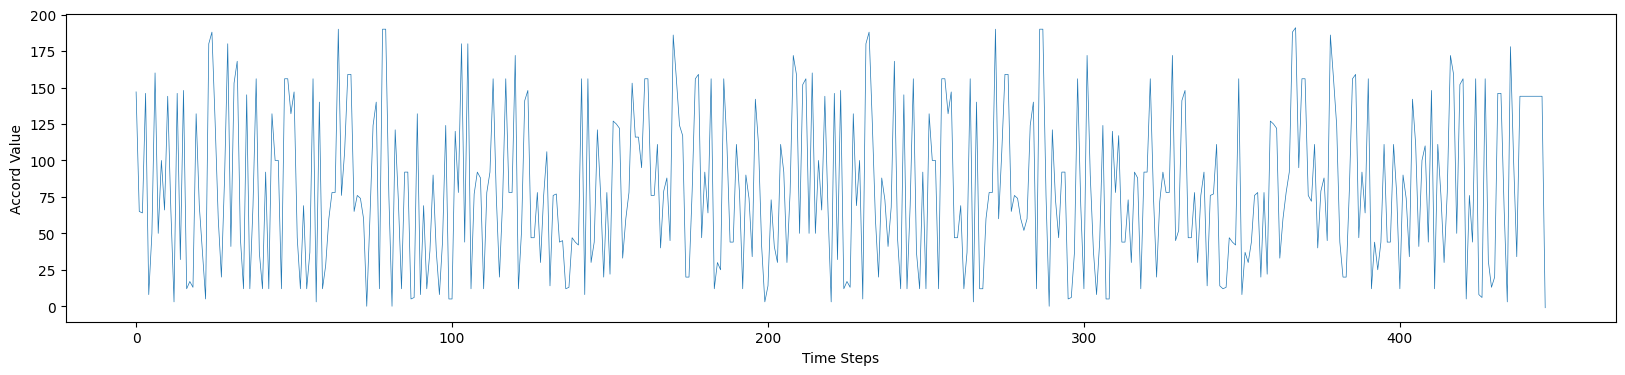

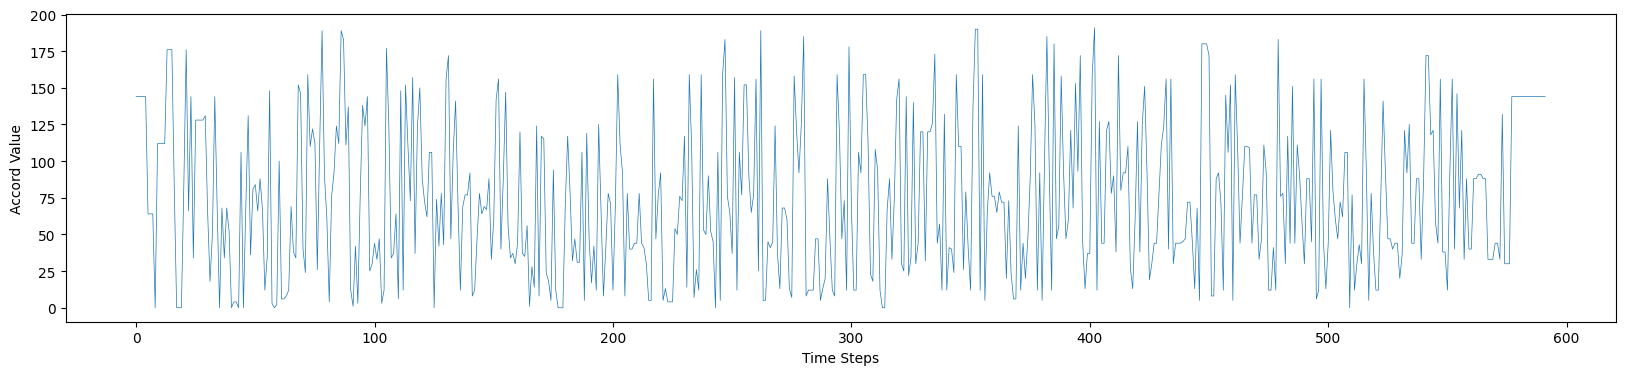

In [61]:
import matplotlib.pyplot as plt


training_examples = dataset[:5]
for sequence, _ in training_examples:
    plt.figure(figsize=(20, 4)) 
    plt.plot(sequence, linewidth=0.5)
    plt.xlabel("Time Steps")
    plt.ylabel("Accord Value")
    plt.show()
    plt.close()

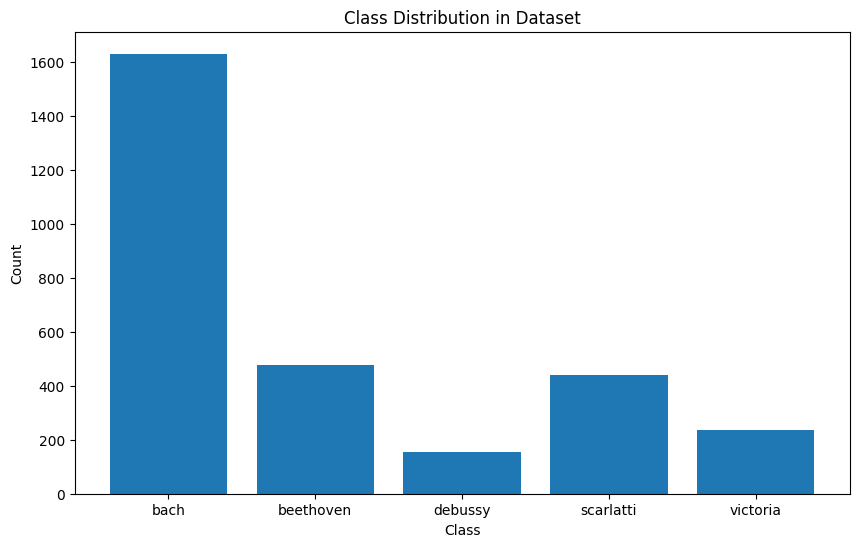

In [62]:
from collections import Counter


labels = [label for _, label in dataset]
class_counts = Counter(labels)
class_names = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
class_labels = [class_names[key] for key in class_counts.keys()]
class_values = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

In [63]:
import torch
from torch.utils.data import Dataset


class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return torch.tensor(in_data, dtype=torch.float32), torch.tensor(target)

In [64]:
from sklearn.model_selection import train_test_split


train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=labels)
train_sequences, train_labels = zip(*train_data)
val_sequences, val_labels = zip(*val_data)
train_set = VariableLenDataset(train_sequences, train_labels)
val_set = VariableLenDataset(val_sequences, val_labels)

In [65]:
from torch.nn.utils.rnn import pad_sequence


def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)

    xx_pad = torch.tensor(xx_pad)
    yy = torch.tensor(yy)
    return xx_pad, yy, x_lens

In [66]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    train_set, batch_size=50, shuffle=True, collate_fn=pad_collate
)
val_loader = DataLoader(
    val_set, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate
)

In [67]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class LSTMRegressor(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, out_size, bidirectional=False
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, hidden, x_len):
        x = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False) # batch_first=True powoduje [batch, seq, feature] -> [seq, batch, feature]
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs, _ = pad_packed_sequence(all_outputs, batch_first=True, padding_value=0)
        batch_size = all_outputs.size(0)
        last_outputs_idx = (torch.tensor(x_len) - 1).to(device) # -1 because of zero indexing
        last_outputs = all_outputs[torch.arange(batch_size), last_outputs_idx, :]
        x = self.fc(last_outputs)
        return x, hidden


model = LSTMRegressor(1, 5, 2, 5, bidirectional=False).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=5, bias=True)
)

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets, x_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)

        logits, _ = model(x, (hidden, state), x_len)

        optimizer.zero_grad()
        loss = loss_fun(logits, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

C:\Users\Piotr\AppData\Local\Temp\ipykernel_23008\40106416.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = torch.tensor(xx_pad)


Epoch: 0, loss: 1.44


KeyboardInterrupt: 

In [ ]:
# with torch.no_grad():
#     for x, targets, x_len, target_len in val_loader:
#         x = x.to(device).unsqueeze(2)
#         targets = targets.to(device)
#         hidden, state = model.init_hidden(x.shape[0])
#         hidden, state = hidden.to(device), state.to(device)

#         #         x = torch.transpose(x, 0, 1)
#         #         preds, _ = model(x, (hidden, state))
#         #         preds = torch.transpose(preds, 0, 1)
#         x_packed = pack_padded_sequence(
#             x, x_len, batch_first=True, enforce_sorted=False
#         )
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(
#             preds_packed, batch_first=True, padding_value=0
#         )

#         preds = preds.squeeze(2)
#         mask_tgt = targets != 0

C:\Users\Piotr\AppData\Local\Temp\ipykernel_18264\40106416.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx_pad = torch.tensor(xx_pad)


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
print(preds)